# Grading method for Mango

This exercise is based on the work by [Pandey R. et al](https://ieeexplore.ieee.org/abstract/document/6968366). The work describes a method to grade the quality of a mango by analysing its colors and dimensions.

## Import packages and define plot functions

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

def plot(img, title, gray=False):
    if gray == True:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.figure()

def plot_hist(channel, title):
    plt.hist(channel.flatten(), 128, [0, 256])
    plt.xlim([0, 256])
    plt.title(title)
    plt.show()
    plt.figure()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define color ranges

The limits allow find the area of mango in the image. They are also useful to find the healthy, diseased, ripe and unripe areas.

In [4]:
MANGO_REGION_LOW_LIMIT = 25
MANGO_REGION_HIGH_LIMIT = 256
MANGO_DISEASED_LOW_LIMIT = 120
MANGO_DISEASED_HIGH_LIMIT = 140
MANGO_MATURITY_LOW_LIMIT = 100
MANGO_MATURITY_HIGH_LIMIT = 125

## Plot each step of the processing

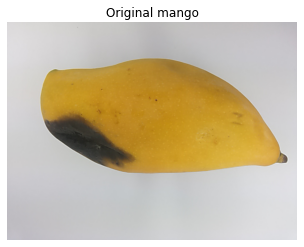

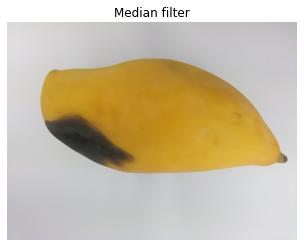

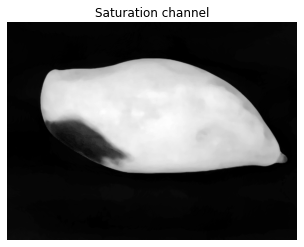

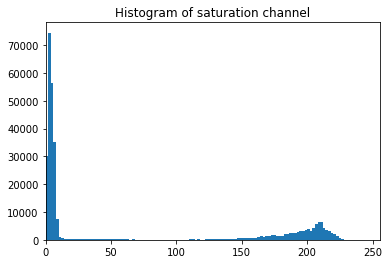

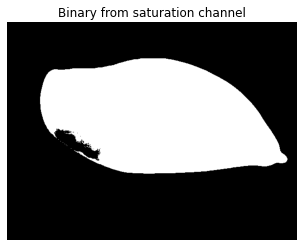

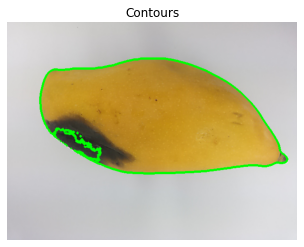

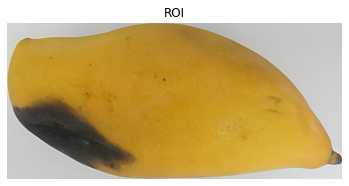

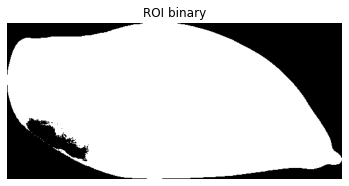

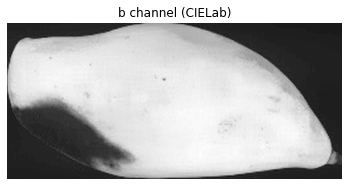

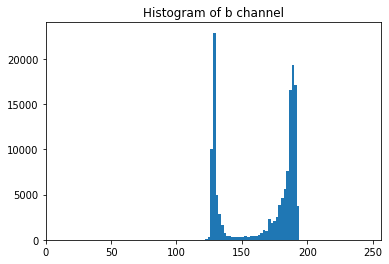

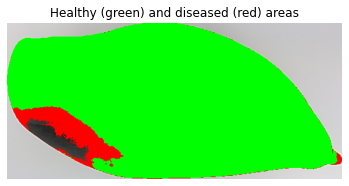

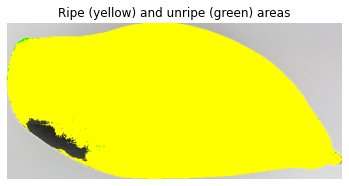

<Figure size 432x288 with 0 Axes>

In [19]:
filename = './images/1 (51).jpg'
img = cv2.imread(filename)

# RGB
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plot(rgb, 'Original mango')

# Median-filtered 
median = cv2.medianBlur(img, 9)
plot(cv2.cvtColor(median, cv2.COLOR_BGR2RGB), 'Median filter')

# HSV
hsv = cv2.cvtColor(median, cv2.COLOR_BGR2HSV)
plot(hsv[:, :, 1], 'Saturation channel', True)

# Saturation histogram
plot_hist(hsv[:, :, 1], 'Histogram of saturation channel')

# Binary
_, binary = cv2.threshold(hsv[:, :, 1], 25, 256, cv2.THRESH_BINARY)
plot(binary, 'Binary from saturation channel', True)

# Contours
imgc, contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
if len(contours) > 0:
    rgb_countours = np.copy(rgb)
    cv2.drawContours(rgb_countours, contours, -1, (0, 255, 0), 3)
    plot(rgb_countours, 'Contours')

    #Bounding box
    main_countour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(main_countour)

    # ROI
    roi_rgb = rgb[y:y+h, x:x+w, :]
    plot(roi_rgb, 'ROI')

    # ROI binary
    roi_binary = binary[y:y+h, x:x+w]
    plot(roi_binary, 'ROI binary', True)
    
    # CIELab
    lab = cv2.cvtColor(roi_rgb, cv2.COLOR_RGB2Lab)
    plot(lab[:, :, 2], 'b channel (CIELab)', True)

    # b histogram
    plot_hist(lab[:, :, 2], 'Histogram of b channel')

    # total number of pixels of mango
    mango_indices = np.where(roi_binary == 255)
    n_mango_pixels = len(mango_indices[0])

    # pixels of diseased areas
    condition_dis = np.logical_and(
        roi_binary == 255,
        np.logical_and(
            lab[:, :, 2] >= MANGO_DISEASED_LOW_LIMIT,
            lab[:, :, 2] <= MANGO_DISEASED_HIGH_LIMIT))
    diseased_pixels = np.where(condition_dis)
    n_diseased_pixels = len(diseased_pixels[0])

    # pixels of healthy areas
    condition_hea = np.logical_and(
        roi_binary == 255,
        lab[:, :, 2] > MANGO_DISEASED_HIGH_LIMIT)
    healthy_pixels = np.where(condition_hea)
    n_healthy_pixels = len(healthy_pixels[0])

    # Color healthy areas as green and diseased ones as red
    roi_diseased = np.copy(roi_rgb)
    roi_diseased[diseased_pixels[0],
                    diseased_pixels[1], :] = [255, 0, 0]
    roi_diseased[healthy_pixels[0],
                    healthy_pixels[1], :] = [0, 255, 0]

    plot(roi_diseased, 'Healthy (green) and diseased (red) areas')

    # pixels of unripe areas
    condition_unripe = np.logical_and(
        roi_binary == 255,
        np.logical_and(
            lab[:, :, 1] >= MANGO_MATURITY_LOW_LIMIT,
            lab[:, :, 1] <= MANGO_MATURITY_HIGH_LIMIT,
        )
    )
    unripe_pixels = np.where(condition_unripe)
    n_unripe_pixels = len(unripe_pixels[0])

    # pixels of ripe areas
    conditioin_ripe = np.logical_and(
        roi_binary == 255,
        lab[:, :, 1] > MANGO_MATURITY_HIGH_LIMIT
    )
    ripe_pixels = np.where(conditioin_ripe)
    n_ripe_pixels = len(ripe_pixels[0])

    # Color ripe areas as yellow and unripe as green
    roi_maturity = np.copy(roi_rgb)
    roi_maturity[unripe_pixels[0],
                    unripe_pixels[1], :] = [0, 255, 0]
    roi_maturity[ripe_pixels[0],
                    ripe_pixels[1], :] = [255, 255, 0]

    plot(roi_maturity, 'Ripe (yellow) and unripe (green) areas')

    # max length of mango
    h, w, d = img.shape
    max_length = max(h, w)

    # normalized major and minor axes
    h, w, d = roi_rgb.shape
    major = max(h, w) / max_length
    minor = min(h, w) / max_length


## Analyse every mango image

A plotless version of the code defined in the previous cell is in the file `mango_analyser.py`. That code is used to analyse every image in the original dataset.

In [6]:
from mango_analyser import calc_mango_quality, calc_mango_feats

def mapMangoQuality(value):
    if value == 0:
        return 'poor'
    elif value == 1:
        return 'medium'
    elif value == 2:
        return 'good'
    elif value == 3:
        return 'excellent'

ds = pd.read_csv('records.csv')
# records.csv contains relative paths to each image. Thus, the variable
# below is used to define the absolute path to each image.
init_path = '/mnt/linux_shared/shared/datasets/Studio'

# Ground truth and predicted values for healthy/diseased mangos
diseased_gt = []
diseased_ca = []

# Ground truth and predicted values for ripe/unripe mangos
ripe_gt = []
ripe_ca = []

# Ground truth and predicted values for small/medium/big/very_big mangos
size_gt = []
size_ca = []

for index, row in ds.iterrows():
    filename = init_path + row['filename'][1:]
    isLabelDiseased = True if row['diseased'] != -1 else False
    isLabelRipe = True if row['ripe'] != -1 and row['ripe'] != 2 else False
    isLabelSize = True if row['size'] != -1 else False

    diseased, healthy, unripe, ripe, major, minor, im_rgb, im_diseased, im_maturity = calc_mango_feats(filename)

    if isLabelDiseased == True:
        diseased_gt.append('diseased' if row['diseased'] == 1 else 'healthy' )
        diseased_ca.append('diseased' if diseased > 20 else 'healthy')

    if isLabelRipe == True:
        ripe_gt.append('ripe' if row['ripe'] == 1 else 'unripe')
        ripe_ca.append('ripe' if ripe > 50 else 'unripe')

    if isLabelSize == True:
        size_gt.append(mapMangoQuality(row['size']))
        size_ca.append(mapMangoQuality(calc_mango_quality(major, minor)))

diseased_gt = pd.Series(diseased_gt, name='Ground Truth')
diseased_ca = pd.Series(diseased_ca, name='Predicted')

ripe_gt = pd.Series(ripe_gt, name='Ground Truth')
ripe_ca = pd.Series(ripe_ca, name='Predicted')

size_gt = pd.Series(size_gt, name='Ground Truth')
size_ca = pd.Series(size_ca, name='Predicted')

## Results of the analysis

The results are presented in terms of confusion matrices.

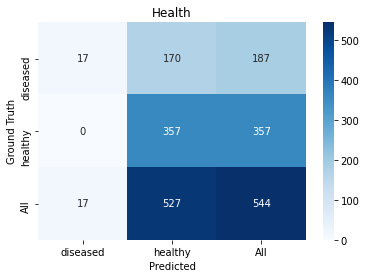

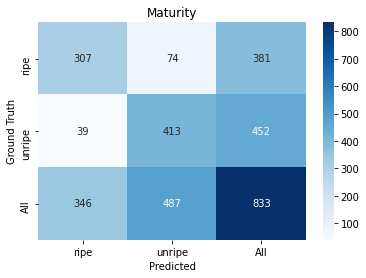

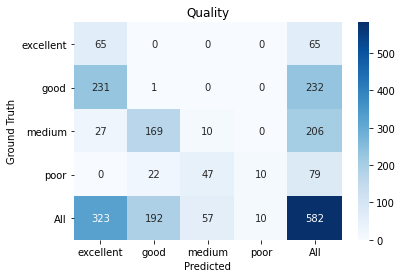

In [17]:
diseased_confusion = pd.crosstab(diseased_gt, diseased_ca, margins=True)
ripe_confusion = pd.crosstab(ripe_gt, ripe_ca, margins=True)
size_confusion = pd.crosstab(size_gt, size_ca, margins=True)

sn.heatmap(diseased_confusion, annot=True, fmt='g', cmap='Blues')
plt.title('Health')
plt.show()

sn.heatmap(ripe_confusion, annot=True, fmt='g', cmap='Blues')
plt.title('Maturity')
plt.show()

sn.heatmap(size_confusion, annot=True, fmt='g', cmap='Blues')
plt.title('Quality')
plt.show()


## Discussion

Confusion matrices show that the accuracy for health, maturity and quality are 68.75%, 86.43% and 14.78%, correspondingly. The values in the original work are 96.95%, 98.88% and 96.85%.

It is clear that the values obtained in this exercise are far from the original ones the closest one is for maturity. The main reason for these differences are the thresholds used to classify each mango. 

The thresholds are not provided in the original work. Thus, they were set (almost) randomly in this exercise.


